<div class="alert alert-success">
Note: if this notebook is taking too long to run, consider using the module HierarchicalClustering v7.3.4 available on gp-beta-ami.genepattern.org

This notebook can be used to find genes which are differentially expressed in two phenotypes. 

A note on some of the parameters we are using:

- **gene expression**: We use a compilation of 40 RNASeq samples taken from TCGA, 20 of those are Breast Cancer primary tumors (BRCA) and 20 are matched normal tissue. Here is the GCT file which contains those HTSeq counts:  
https://raw.githubusercontent.com/genepattern/differential-expression-modalities/master/data/workshop_BRCA_filtered.gct  

- **phenotype file**: We will use this CLS file to identify the samples' phenotype   
https://raw.githubusercontent.com/genepattern/differential-expression-modalities/master/data/workshop_BRCA_labels.cls

In [1]:
import genepattern
# import cuzcatlan as cusca
# import pandas as pd    
from cuzcatlan import hc_samples

genepattern.GPUIBuilder(hc_samples, name="Hierarchical Clustering of Samples (Columns).", 
                        description="This function performs hierarchical clustering to group samples (columns) with similar phenotypes..",
                        parameters={
                                "distance_metric":{
                                                      "default": "pearson",
                                                      "choices":{'Pearson Correlation':"pearson",
                                                                 'Information Coefficient':"information_coefficient",
                                                                 'Euclidean':"euclidean",
                                                                }
                                                     }
                        })

GPUIBuilder(description='This function performs hierarchical clustering to group samples (columns) with similar phenotypes..', function_import='hc_samples', name='Hierarchical Clustering of Samples (Columns).', params=[{'name': 'input_gene_expression', 'label': 'input_gene_expression', 'optional': False, 'default': '', 'description': 'gene expression data filename (.gct file) where rows are genes and columns are samples', 'hide': False, 'type': 'text', 'kinds': None, 'choices': []}, {'name': 'clustering_type', 'label': 'clustering_type', 'optional': False, 'default': '', 'description': 'single or consensus -- Only single is suported at the moment', 'hide': False, 'type': 'text', 'kinds': None, 'choices': []}, {'name': 'distance_metric', 'label': 'distance_metric', 'optional': False, 'default': 'pearson', 'description': 'the function to be used when comparing the distance/similarity of the columns in the input_gene_expression dataset', 'hide': False, 'type': 'text', 'kinds': None, 'choices': {'Pearson Correlation': 'pearson', 'Information Coefficient': 'information_coefficient', 'Euclidean': 'euclidean'}}, {'name': 'file_basename', 'label': 'file_basename', 'optional': True, 'default': 'HC_out', 'description': 'the name to use when naming output files', 'hide': False, 'type': 'text', 'kinds': None, 'choices': []}, {'name': 'clusters_to_highlight', 'label': 'clusters_to_highlight', 'optional': True, 'default': 'None', 'description': 'how many clusters to highlight in the dendrogram', 'hide': False, 'type': 'text', 'kinds': None, 'choices': []}])

Currenty clustering_type is being ignored, only single is supported.
This are the parameters to be used (for debugging purposes)

    pwd = '.'
    gct_name = test_data/test_BRCA_minimal_60x19.gct
    col_distance_metric = pearson
    output_distances = False
    row_distance_metric = No_row_clustering
    clustering_method = average
    output_base_name = HC_out
    row_normalization = False
    col_normalization = False
    row_centering = Mean
    col_centering = Mean
    
Now we will start performing hierarchical clustering, this may take a little while.
----------------------------------------------------------------------
The PDF of this heatmap can be downloaded here:


----------------------------------------------------------------------
The CDF which is compatible with HierarchicalClusteringViewer is here:


----------------------------------------------------------------------
The ATR which is compatible with HierarchicalClusteringViewer is here:


----------------------------------------------------------------------


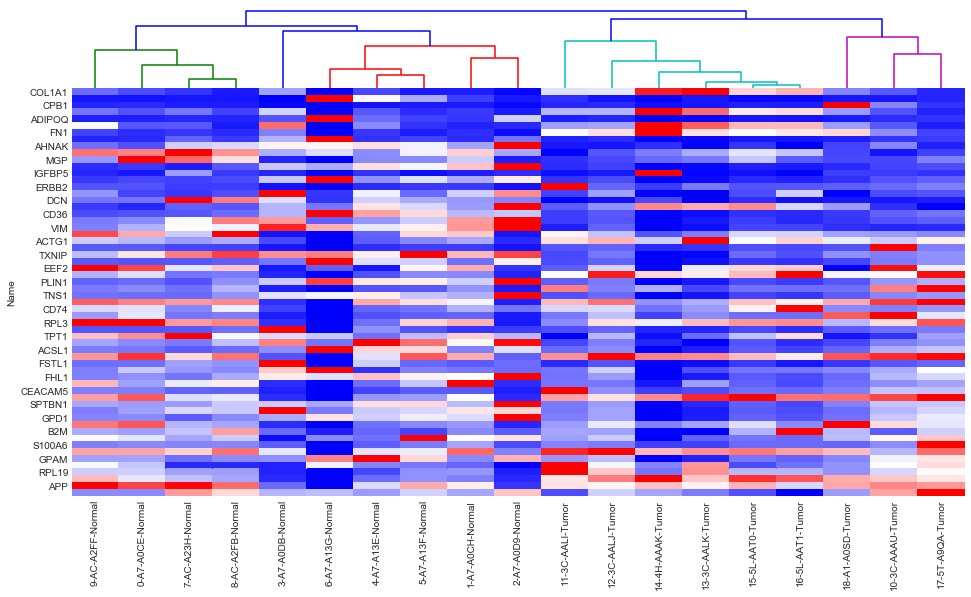

Done with Hierarchical Clustering!


In [2]:
col_model = hc_samples(input_gene_expression="test_data/test_BRCA_minimal_60x19.gct", clustering_type="single", distance_metric="pearson", file_basename="HC_out")